# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

- Признаки

DateCrawled — дата скачивания анкеты из базы\
VehicleType — тип автомобильного кузова\
RegistrationYear — год регистрации автомобиля\
Gearbox — тип коробки передач\
Power — мощность (л. с.)\
Model — модель автомобиля\
Kilometer — пробег (км)\
RegistrationMonth — месяц регистрации автомобиля\
FuelType — тип топлива\
Brand — марка автомобиля\
NotRepaired — была машина в ремонте или нет\
DateCreated — дата создания анкеты\
NumberOfPictures — количество фотографий автомобиля\
PostalCode — почтовый индекс владельца анкеты (пользователя)\
LastSeen — дата последней активности пользователя

- Целевой признак

Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
import lightgbm as lgb

from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('C:/Users/ilyag/Downloads/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired имеются пропущенные значения.

In [4]:
# количество пропусков
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
# приведение строк к нижнему регистру
df.columns = df.columns.str.lower()
df.tail(3)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [6]:
# поиск явных дубликатов
df.loc[df.duplicated()==True]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Удалим обнаруженные дубликаты.

In [7]:
df = df.drop_duplicates()

Заполним пропущенные категориальные значения столбцов на unknown.

In [8]:
list_isna = ['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired']

for element in list_isna:
    df[element] = df[element].fillna('unknown')

In [9]:
# df['vehicletype'] = (df.groupby(['brand', 'model'])['vehicletype']
#                      .transform(lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else 'unknown'))))

In [10]:
df.numberofpictures.value_counts()

0    354365
Name: numberofpictures, dtype: int64

В столбце numberofpictures (количество фотографий) фото отсутствуют во всех объектах.

Удалим ненужные для последующего обучения модели столбцы datecrawled, registrationmonth, datecreated, numberofpictures, postalcode, lastseen.

In [11]:
df = df.drop(['datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,unknown,2005,unknown,0,unknown,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


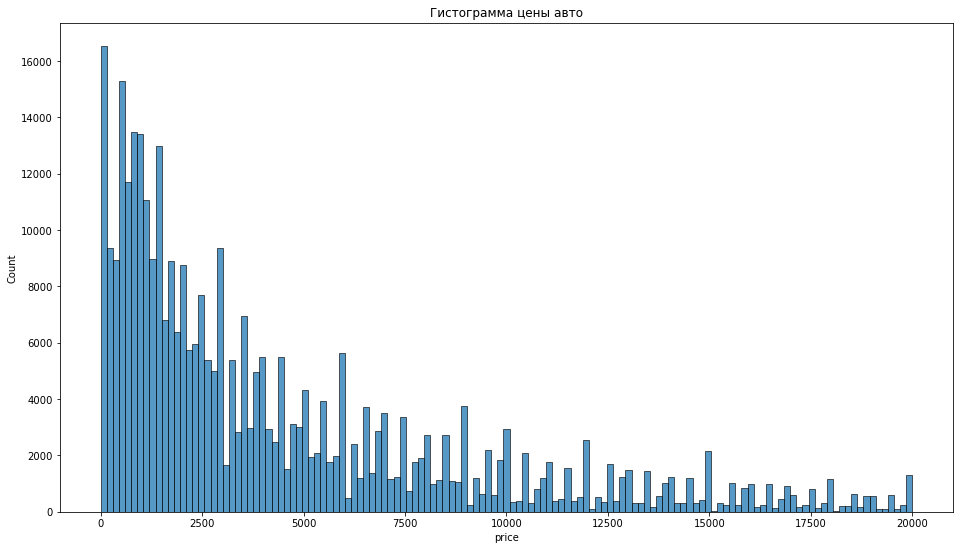

In [12]:
plt.figure(figsize=(16,9))
plt.title('Гистограмма цены авто')
sns.histplot(data=df.price);

В данных имеется большое количество авто с аномально низкими ценами. Рассмотрим эти данные.

In [13]:
df.query('0 <= price < 200')

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,unknown,1990,unknown,0,corsa,150000,petrol,opel,unknown
59,1,suv,1994,manual,286,unknown,150000,unknown,sonstige_autos,unknown
79,150,unknown,2016,manual,75,astra,150000,petrol,opel,yes
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
...,...,...,...,...,...,...,...,...,...,...
354273,150,small,1993,manual,55,astra,150000,petrol,opel,yes
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
354309,99,small,1999,manual,60,arosa,150000,petrol,seat,yes
354338,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown


Обнаруживаются авто с ценами 0, 1, а также дешёвые экземпляры из малогабаритных авто. Возможно 0, 1 и тп это какие-то стартовые аукционные стоимости авто. Наличие таких моделей в датасете не отвечает задачам исследования. Эти данные можно отфильтровать.

In [14]:
# удалим строки с нулевой и аномально низкой ценой на авто
# df = df.drop(df[df.price == 0].index)
df = df.query('200 < price')

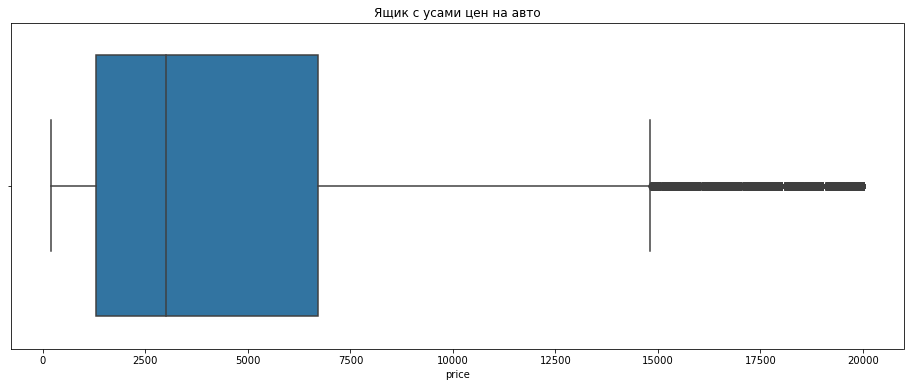

In [15]:
plt.figure(figsize=(16,6))
plt.title('Ящик с усами цен на авто')
sns.boxplot(data=df, x='price');

In [16]:
# уникальные значения столбца с годом регистрации авто
df.registrationyear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2015,
       1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1941,
       9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 2066, 1949,
       2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300, 9000, 2900,
       6000, 1000, 5911, 1400, 5000, 4000, 1948, 1952, 8500, 1932, 1950,
       3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 1923, 2290, 1930,
       1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555, 1600, 1111,
       1039, 3000, 2800, 1931, 4500, 1602, 7800, 1947, 1927, 7100, 1300,
       8200, 1946], dtype=int64)

Видно что присутствуют ошибочные значения. Отфильтруем датафрейм с помощью query.

In [17]:
# df = df.query('1900 < registrationyear <= 2022')
df = df.query('1970 <= registrationyear <= 2022')

In [18]:
df.registrationyear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007,
       2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2015, 1985,
       1982, 1976, 1983, 1973, 1971, 1987, 1988, 1980, 1970, 1986, 1974,
       1979, 1978, 1972, 1977, 1975, 2019], dtype=int64)

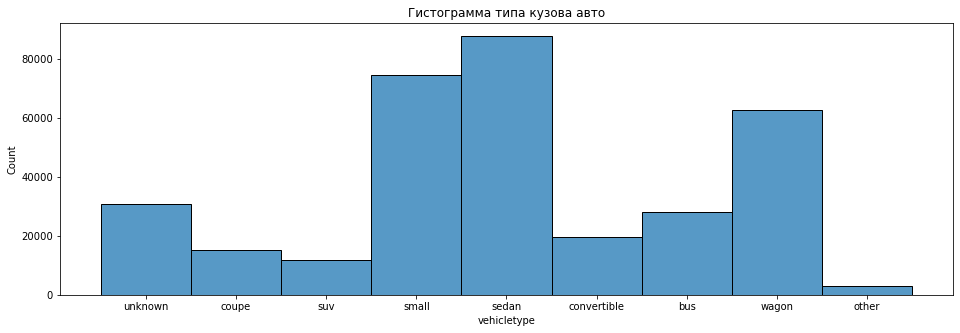

In [19]:
plt.figure(figsize=(16,5))
plt.title('Гистограмма типа кузова авто')
sns.histplot(data=df.vehicletype);

Чаще всего встречаются седаны, универсалы и компактные в соответствии с европейской классификацией авто.

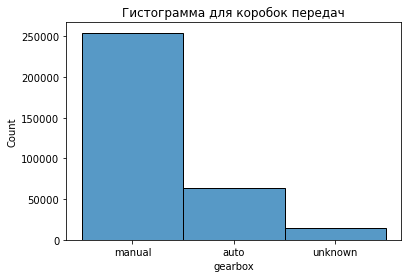

In [20]:
plt.title('Гистограмма для коробок передач')
sns.histplot(data=df.gearbox);

Подавляющее количество авто имеет механическую коробку передач.

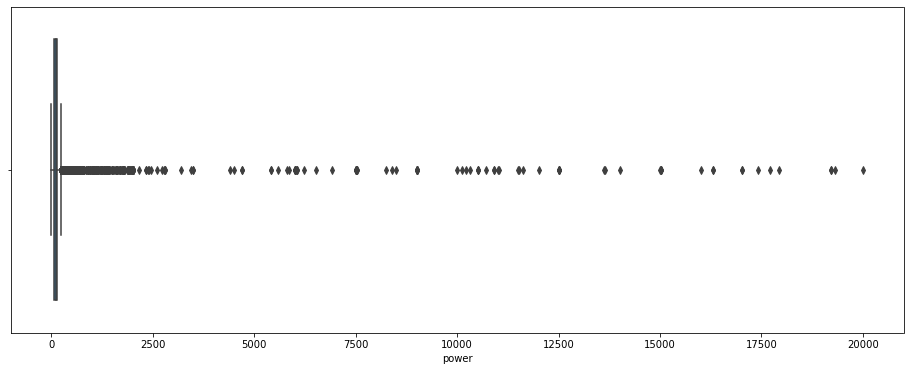

In [21]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df, x='power');

Максимальную мощность авто имело смысл ограничить до максимальной существующей на сегодняшний день 1600 л.с. Однако, при рассмотрении данных обнаруживается значительное количество аномальных для соответствующей марки/модели/года выпуска авто значений мощности.

In [22]:
df.query('power > 1600')['power'].count()

157

In [23]:
df.query('power > 500')['power'].count()

401

In [24]:
# pd.set_option('display.max_rows', None)
df.query('500 < power < 1600')

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,unknown
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,unknown
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,unknown
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,unknown


In [25]:
df.query('power == 0')

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,unknown,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,unknown,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354335,390,small,1997,auto,0,corsa,100000,petrol,opel,yes
354336,3299,unknown,2005,auto,0,outlander,150000,petrol,mitsubishi,unknown
354346,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


In [26]:
# pd.set_option('display.max_rows', None)
df.query('0 < power < 20')

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
431,3950,small,2004,auto,5,unknown,70000,gasoline,sonstige_autos,no
3349,1990,small,2004,unknown,7,polo,150000,gasoline,volkswagen,no
4637,870,wagon,2000,manual,16,focus,150000,unknown,ford,no
9561,9000,sedan,2009,manual,2,a4,5000,gasoline,audi,unknown
11228,9900,small,1970,manual,18,500,30000,petrol,fiat,no
...,...,...,...,...,...,...,...,...,...,...
348891,5690,small,2014,auto,18,other,10000,electric,renault,no
348975,1850,small,2003,auto,5,unknown,50000,gasoline,sonstige_autos,yes
349666,1500,unknown,2016,unknown,2,unknown,150000,gasoline,volkswagen,unknown
353127,8600,convertible,2012,manual,8,unknown,5000,gasoline,sonstige_autos,no


Отфильтруем датафрейм от аномальных и нулевых значений мощности.

In [27]:
df = df.query('45 < power < 500')

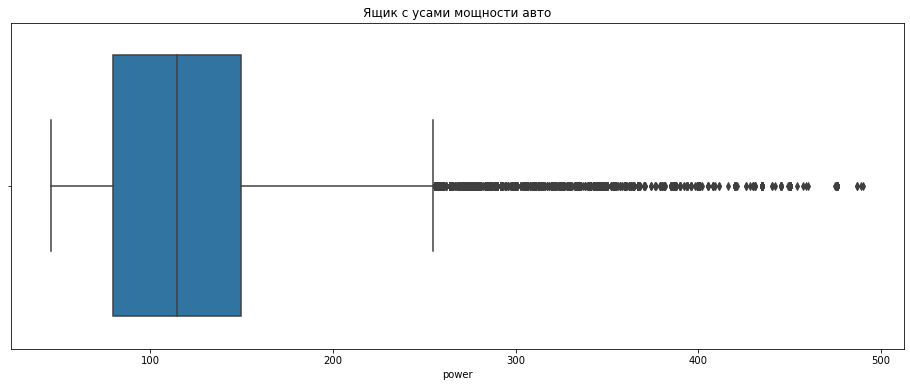

In [28]:
plt.figure(figsize=(16,6))
plt.title('Ящик с усами мощности авто')
sns.boxplot(data=df, x='power');

In [29]:
# df.query('400 < power < 500')

In [30]:
# уникальные значения пробега в км
df.kilometer.unique()

array([125000, 150000,  90000,  30000,  70000, 100000,  60000,   5000,
        20000,  80000,  50000,  40000,  10000], dtype=int64)

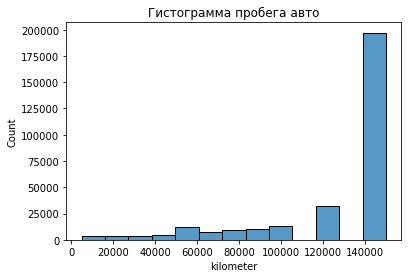

In [31]:
plt.title('Гистограмма пробега авто')
sns.histplot(data=df.kilometer, bins=13);

Подявляющее большинство авто имеет большой пробег.

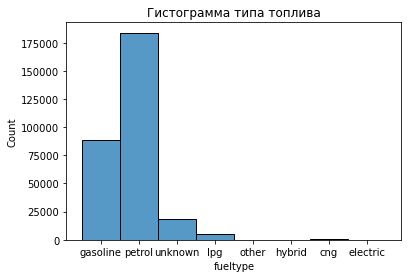

In [32]:
plt.title('Гистограмма типа топлива')
sns.histplot(data=df.fueltype);

По сути gasoline и petrol это характерные для Британии и США названия бензина. В рамках исследования можно объединить их в одну категорию.

In [33]:
df.loc[df["fueltype"] == "gasoline", "fueltype"] = 'petrol'

In [34]:
# plt.title('Гистограмма типа топлива')
# sns.histplot(data=df.fueltype);

In [35]:
df.fueltype.value_counts()

petrol      272394
unknown      18099
lpg           4746
cng            494
hybrid         203
other           52
electric        36
Name: fueltype, dtype: int64

In [36]:
df.brand.value_counts()

volkswagen        64650
bmw               32833
opel              31638
mercedes_benz     27840
audi              26199
ford              20411
renault           13946
peugeot            9303
fiat               7349
seat               5973
skoda              5017
mazda              4798
citroen            4208
toyota             4107
nissan             4037
smart              3720
hyundai            3160
mini               3034
volvo              2813
mitsubishi         2499
honda              2440
kia                2146
alfa_romeo         1999
suzuki             1924
sonstige_autos     1476
chevrolet          1467
chrysler           1163
dacia               821
subaru              631
porsche             616
jeep                578
daihatsu            547
saab                478
land_rover          466
jaguar              431
daewoo              404
lancia              373
rover               364
lada                158
trabant               7
Name: brand, dtype: int64

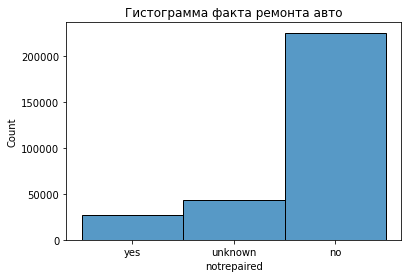

In [37]:
plt.title('Гистограмма факта ремонта авто')
sns.histplot(data=df.notrepaired);

### Вывод

Данные подготовлены для дальнейшей работы.
- Устранены аномалии, выбросы
- Удалены дубликаты
- Заполнены пропущенные значения

In [38]:
#код ревьюера
df.describe(include = 'all')

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
count,296024.000000,296024,296024.000000,296024,296024.000000,296024,296024.000000,296024,296024,296024
unique,NaN,9,NaN,3,NaN,250,NaN,7,40,3
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,81627,NaN,231715,NaN,25519,NaN,272394,64650,225208
mean,4930.321896,NaN,2003.574859,NaN,122.099532,NaN,128597.174553,NaN,NaN,NaN
std,4584.307896,NaN,6.518077,NaN,52.506263,NaN,36441.451800,NaN,NaN,NaN
min,202.000000,NaN,1970.000000,NaN,46.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1450.000000,NaN,1999.000000,NaN,80.000000,NaN,125000.000000,NaN,NaN,NaN
50%,3299.000000,NaN,2004.000000,NaN,115.000000,NaN,150000.000000,NaN,NaN,NaN
75%,7000.000000,NaN,2008.000000,NaN,150.000000,NaN,150000.000000,NaN,NaN,NaN


## Обучение моделей

Разобьём данные на выборки и подготовим категориальные признаки для обучения моделей.

In [39]:
# # разбиение данных на выборки
# features_train, features_test, target_train, target_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.25, random_state=12345)

In [40]:
# # проверка
# display(features_train.shape)
# display(features_test.shape)
# display(target_train.shape)
# target_test.shape

Порядковое кодирование.

In [41]:
encoder = OrdinalEncoder()
encoder.fit(df)
data_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

target = data_ordinal['price']
features = data_ordinal.drop('price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [42]:
data_ordinal

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,3370.0,2.0,41.0,1.0,144.0,227.0,11.0,5.0,1.0,2.0
1,2393.0,6.0,34.0,0.0,117.0,117.0,11.0,5.0,14.0,1.0
2,542.0,5.0,31.0,1.0,29.0,116.0,12.0,5.0,38.0,0.0
3,1158.0,5.0,38.0,1.0,23.0,101.0,9.0,5.0,31.0,0.0
4,212.0,4.0,25.0,1.0,56.0,11.0,12.0,5.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
296019,1561.0,7.0,46.0,0.0,104.0,4.0,12.0,6.0,0.0,0.0
296020,1055.0,4.0,34.0,1.0,179.0,140.0,12.0,5.0,30.0,2.0
296021,426.0,1.0,30.0,0.0,55.0,106.0,11.0,5.0,32.0,0.0
296022,2296.0,0.0,26.0,1.0,56.0,223.0,12.0,5.0,38.0,0.0


In [43]:
# проверка
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
target_test.shape

(222018, 9)

(74006, 9)

(222018,)

(74006,)

Масштабирование данных.

In [44]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [45]:
# функция обучения и определения RMSE моделей
def box_model_rmse(model, features_train, target_train, features_test, target_test):
    rmse = math.sqrt(mean_squared_error(target_test, model.fit(features_train, target_train).predict(features_test)))
    return print('RMSE:', rmse)

### DecisionTreeRegressor

In [46]:
%%time
# решающее дерево со стандартными параметрами
box_model_rmse(DecisionTreeRegressor(), features_train, target_train, features_test, target_test)

RMSE: 374.2302461798436
Wall time: 1.02 s


In [47]:
%%time
# подбор гиперпараметров для решающего дерева
parameters = { 'max_depth': range (1,20, 2) }
rgs = DecisionTreeRegressor(random_state=12345)
grid = GridSearchCV(rgs, parameters, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
predictions_tree = grid.predict(features_test)

display(grid.best_params_)
grid.best_score_

{'max_depth': 15}

Wall time: 22.1 s


-362.55970503203906

### RandomForestRegressor

In [48]:
%%time
# случайный лес со стандартными гиперпараметрами
box_model_rmse(RandomForestRegressor(), features_train, target_train, features_test, target_test)

RMSE: 309.4317143726135
Wall time: 1min 11s


In [49]:
%%time
# подбор гиперпараметров для случайного леса
parameters = { 'n_estimators': (10, 20, 50, 100),
              'max_depth': (1, 5, 10, 20) }
clf = RandomForestRegressor(random_state=12345)
grid = GridSearchCV(clf, parameters, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
predictions_valid = grid.predict(features_test)

display(grid.best_params_)
grid.best_score_

{'max_depth': 20, 'n_estimators': 100}

Wall time: 15min 17s


-312.87486448825814

Подбор гиперпараметров не улучшил работу модели случайного леса.

### LinearRegression

In [50]:
%%time
box_model_rmse(LinearRegression(), features_train, target_train, features_test, target_test)

RMSE: 575.6605955565099
Wall time: 149 ms


Обучается быстро, но даёт значимо боолее низкий результат работы, чем модели с деревьями. 

### CatBoostRegressor

In [51]:
%%time
box_model_rmse(CatBoostRegressor(), features_train, target_train, features_test, target_test)

Learning rate set to 0.096141
0:	learn: 856.6247383	total: 224ms	remaining: 3m 44s
1:	learn: 805.8036174	total: 255ms	remaining: 2m 7s
2:	learn: 758.8332218	total: 284ms	remaining: 1m 34s
3:	learn: 717.5855077	total: 312ms	remaining: 1m 17s
4:	learn: 681.9757449	total: 341ms	remaining: 1m 7s
5:	learn: 649.8175314	total: 370ms	remaining: 1m 1s
6:	learn: 621.5794404	total: 402ms	remaining: 57s
7:	learn: 596.9224557	total: 432ms	remaining: 53.5s
8:	learn: 575.2531780	total: 467ms	remaining: 51.4s
9:	learn: 555.2505838	total: 497ms	remaining: 49.2s
10:	learn: 538.6545222	total: 527ms	remaining: 47.4s
11:	learn: 522.6810083	total: 555ms	remaining: 45.7s
12:	learn: 509.0541483	total: 584ms	remaining: 44.3s
13:	learn: 496.8629101	total: 612ms	remaining: 43.1s
14:	learn: 485.6485431	total: 639ms	remaining: 41.9s
15:	learn: 476.0245036	total: 673ms	remaining: 41.4s
16:	learn: 467.5768857	total: 702ms	remaining: 40.6s
17:	learn: 459.2323318	total: 730ms	remaining: 39.8s
18:	learn: 452.3103328	to

Обучается достаточно быстро (быстрее случайного леса даже со стандартными параметрами) и даёт сопоставимый с ним результат.

### LGBMRegressor

In [52]:
%%time
box_model_rmse(lgb.LGBMRegressor(), features_train, target_train, features_test, target_test)

RMSE: 327.0076467213658
Wall time: 1.55 s


In [53]:
%%time
# подбор параметров LGBMRegressor
parameters = { 'n_estimators': (10, 100),
              'max_depth': (3, 5) }
lgbm = lgb.LGBMRegressor(random_state=12345)
grid = GridSearchCV(lgbm, parameters, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
predictions_valid = grid.predict(features_test)

display(grid.best_params_)
grid.best_score_

{'max_depth': 5, 'n_estimators': 100}

Wall time: 14.1 s


-337.06874480274365

RMSE модели несколько хуже случайного леса и CatBoost, однако обучается быстрее этих моделей если не требуется подбор параметров.

### Dummy model

Построим dummy модель для проверки адекватности работы других моделей обучения.

In [54]:
%%time
box_model_rmse(DummyRegressor(strategy="mean"), features_train, target_train, features_test, target_test)

RMSE: 916.0661842472579
Wall time: 4 ms


### Вывод

- По результатам работы моделей были получены необходимые для анализа метрики RMSE и время работы.
- Все модели прошли тест на адекватность, показав результаты работы превосходящие dummy модель.

## Анализ моделей

Создадим датафрейм с результатами и времени работы моделей.

In [57]:
model_dict = {'Model_name': ['DecisionTreeRegressor',
                             'RandomForestRegressor',
                             'LinearRegression',
                             'CatBoostRegressor',
                             'LGBMRegressor',
                             'DummyRegressor'],
             'RMSE': [362, 309, 575, 309, 327, 916],
              'Time': ['22.1 s', '71 s', '149 ms', '30.3 s', '1.55 s', '4 ms']}
df_result = pd.DataFrame(model_dict)
df_result

,Model_name,RMSE,Time
0,DecisionTreeRegressor,362,22.1 s
1,RandomForestRegressor,309,71 s
2,LinearRegression,575,149 ms
3,CatBoostRegressor,309,30.3 s
4,LGBMRegressor,327,1.55 s
5,DummyRegressor,916,4 ms


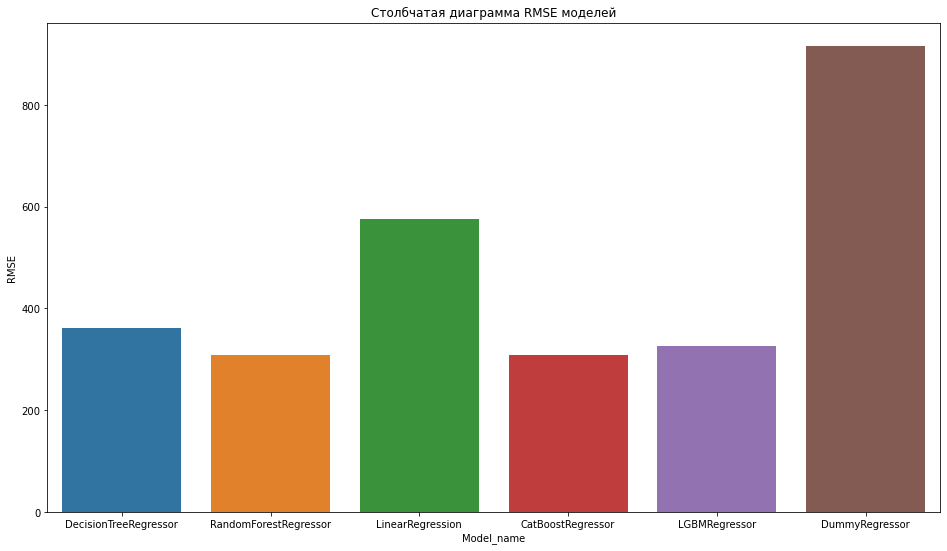

In [58]:
plt.figure(figsize=(16,9))
plt.title('Столбчатая диаграмма RMSE моделей')
sns.barplot(x='Model_name', y='RMSE', data=df_result);

### Вывод

Модели случайного леса и CatBoost показали лучшие результаты RMSE. Несколько хуже по этому показателю оказалась модель LGBMRegressor. Время работы моделей LGBMRegressor и RandomForest из коробки также значительно меньше времени работы с подбором гиперпараметров. При этом подбор параметров не улучшил качество работы моделей.

## Общий вывод

- Лучшими моделями по показателю RMSE стали RandomForestRegressor, CatBoostRegressor и LGBMRegressor (в порядке возрастания ошибки). RandomForestRegressor и CatBoostRegressor при этом показали сопоставимые результаты, LGBMRegressor показал результат немного хуже.
- При этом LGBMRegressor сработал быстрее CatBoostRegressor и RandomForestRegressor.
- Самыой быстрой моделью оказалась LinearRegression, однако качество работы LinearRegression существенно уступает остальным.

**В соответствии с заданными параметрами выбора модели по качеству предсказаний и скорости обучения, лучшей моделью для определения стоимости автомобиля можно считать LGBMRegressor (учитывая скорость обучения) при условии что мы берём модель "из коробки", хотя более точной является CatBoost.**

**Если для улчешения работы модели требуется подбор гиперпараметров, что значительно замедляет работы LGBMRegressor, оптимальной моделью будет CatBoost.**